# SMS Spam Detection

Load data, EDA, model comparison, select best model, and detailed evaluation.

In [11]:
# Setup
RANDOM_STATE = 42
import warnings; warnings.filterwarnings('ignore')

import sys, subprocess
def _ensure(pkg):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

for pkg in ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'wordcloud', 'joblib']:
    _ensure(pkg)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from joblib import dump

sns.set(style='whitegrid', context='notebook')
plt.rcParams['figure.dpi'] = 120
np.random.seed(RANDOM_STATE)

## 1. Load Data

In [12]:
df_raw = pd.read_csv('spam.csv', encoding='latin-1')
df_raw.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## 2. Preprocess
- Keeping label and message columns
- Cleaning nulls/duplicates

In [13]:
df = df_raw[['v1', 'v2']].rename(columns={'v1': 'label_name', 'v2': 'message'})
df = df.dropna().drop_duplicates()
df['label_name'] = df['label_name'].map({'ham': 'Not Spam', 'spam': 'Spam'})
df = df[df['label_name'].isin(['Not Spam', 'Spam'])].copy()
df['label'] = df['label_name'].map({'Not Spam': 0, 'Spam': 1}).astype(int)
df[['label_name', 'message', 'label']].head()

,label_name,message,label
0,Not Spam,"Go until jurong point, crazy.. Available only ...",0
1,Not Spam,Ok lar... Joking wif u oni...,0
2,Spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,Not Spam,U dun say so early hor... U c already then say...,0
4,Not Spam,"Nah I don't think he goes to usf, he lives aro...",0


## 3. Exploratory Data Analysis (EDA)

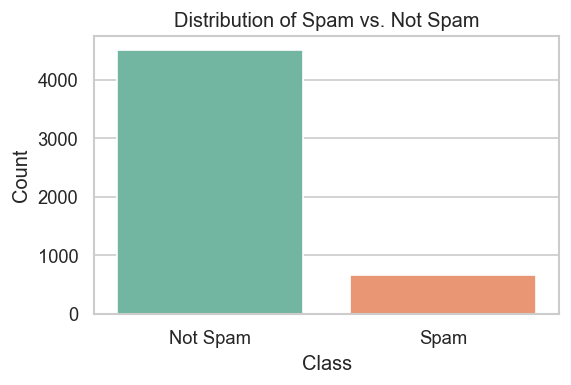

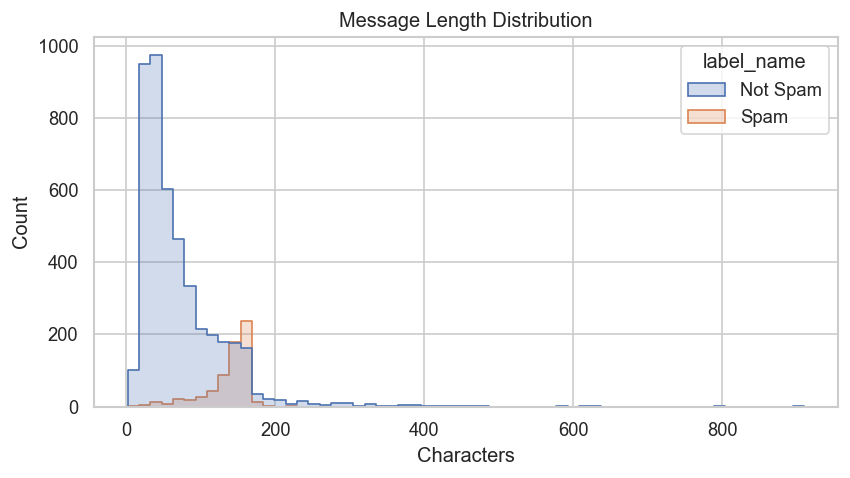

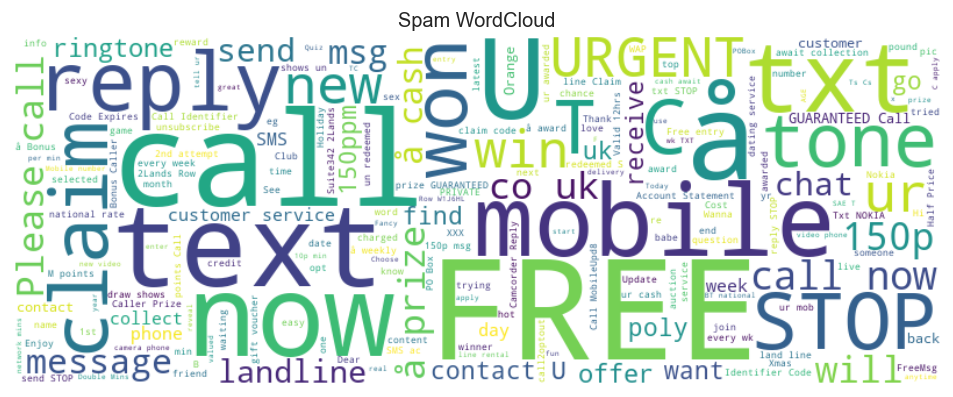

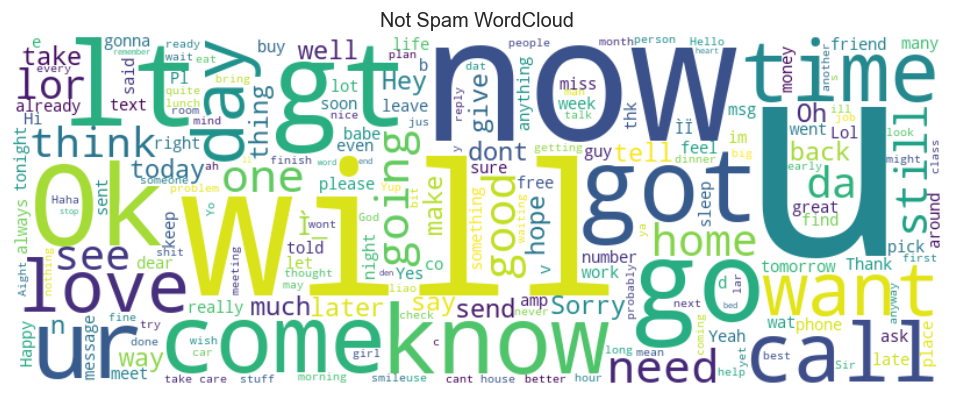

In [4]:
# Class distribution
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='label_name', palette=['#66c2a5', '#fc8d62'])
plt.title('Distribution of Spam vs. Not Spam')
plt.xlabel('Class'); plt.ylabel('Count')
plt.show()

# Message length
df['message_len'] = df['message'].str.len()
plt.figure(figsize=(8,4))
sns.histplot(df, x='message_len', hue='label_name', bins=60, element='step', stat='count', common_norm=False)
plt.title('Message Length Distribution')
plt.xlabel('Characters'); plt.ylabel('Count')
plt.show()

# Word clouds
spam_text = ' '.join(df[df['label']==1]['message'].tolist())
ham_text  = ' '.join(df[df['label']==0]['message'].tolist())

plt.figure(figsize=(10,4))
wc_spam = WordCloud(width=800, height=300, background_color='white').generate(spam_text)
plt.imshow(wc_spam, interpolation='bilinear'); plt.axis('off'); plt.title('Spam WordCloud')
plt.show()

plt.figure(figsize=(10,4))
wc_ham = WordCloud(width=800, height=300, background_color='white').generate(ham_text)
plt.imshow(wc_ham, interpolation='bilinear'); plt.axis('off'); plt.title('Not Spam WordCloud')
plt.show()

## 4. Train/Test Split and Pipelines
We compare multiple models using a shared TF‑IDF vectorizer inside scikit-learn Pipelines.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = df['message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2, max_df=0.9)

candidates = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Linear SVM': LinearSVC(random_state=RANDOM_STATE),
    'Multinomial NB': MultinomialNB(),
    'Complement NB': ComplementNB(),
    'Random Forest': RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVC (RBF)': SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
}

pipelines = {name: Pipeline([
    ('tfidf', vectorizer),
    ('clf', model)
]) for name, model in candidates.items()}

## 5. Model Comparison
We fit each pipeline and evaluate on the test set.

In [6]:
results = []
fitted = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }
    results.append(metrics)
    fitted[name] = pipe

results_df = pd.DataFrame(results).sort_values('F1', ascending=False).reset_index(drop=True)
results_df

,Model,Accuracy,Precision,Recall,F1
0,Linear SVM,0.981625,0.982759,0.870229,0.923077
1,Random Forest,0.976789,0.981982,0.832061,0.900826
2,Complement NB,0.973888,0.876812,0.923664,0.899628
3,SVC (RBF),0.975822,0.990741,0.816794,0.895397
4,Multinomial NB,0.969052,1.000000,0.755725,0.860870
5,Decision Tree,0.963250,0.878049,0.824427,0.850394
6,Logistic Regression,0.957447,0.988764,0.671756,0.800000
7,KNN,0.902321,1.000000,0.229008,0.372671


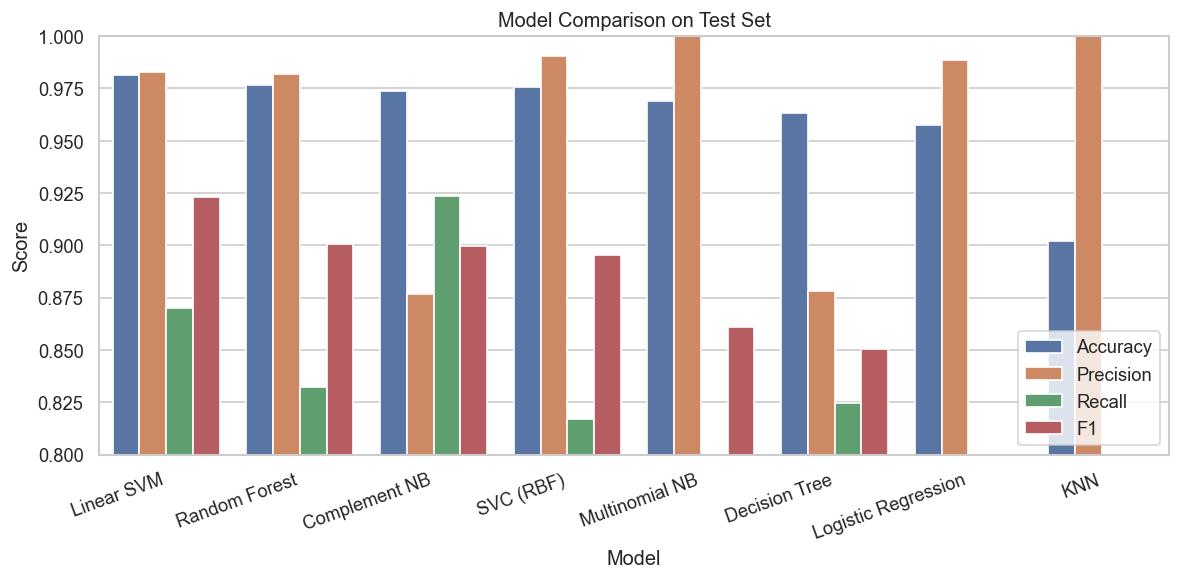

In [7]:
# Visualize metrics
melted = results_df.melt(id_vars=['Model'], value_vars=['Accuracy','Precision','Recall','F1'], var_name='Metric', value_name='Score')
plt.figure(figsize=(10,5))
sns.barplot(data=melted, x='Model', y='Score', hue='Metric')
plt.ylim(0.8, 1.0)
plt.title('Model Comparison on Test Set')
plt.xticks(rotation=20, ha='right')
plt.legend(loc='lower right')
plt.tight_layout(); plt.show()

## 6. Best Model: Detailed Evaluation

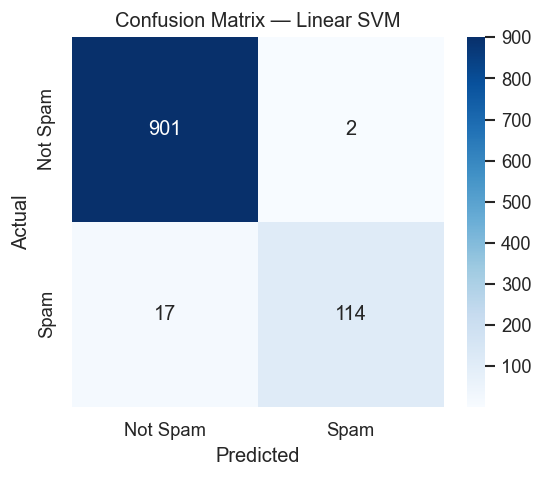

              precision    recall  f1-score   support

    Not Spam       0.98      1.00      0.99       903
        Spam       0.98      0.87      0.92       131

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.96      1034
weighted avg       0.98      0.98      0.98      1034



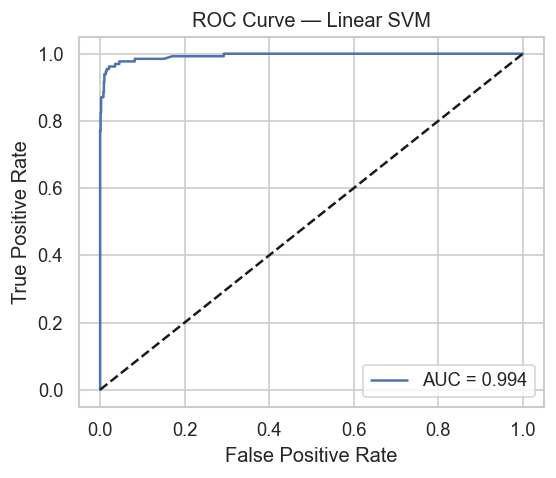

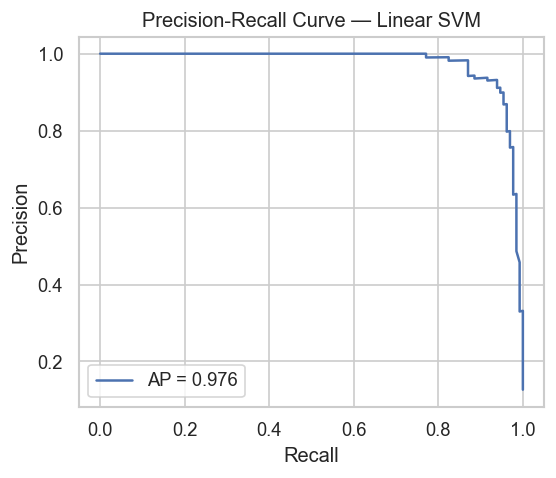

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

best_name = results_df.iloc[0]['Model']
best_pipe = fitted[best_name]
y_pred = best_pipe.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam','Spam'], yticklabels=['Not Spam','Spam'])
plt.title(f'Confusion Matrix — {best_name}')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

print(classification_report(y_test, y_pred, target_names=['Not Spam','Spam']))

# Curves (if scores available)
scores = None
clf = best_pipe.named_steps['clf']
try:
    scores = best_pipe.predict_proba(X_test)[:,1]
except Exception:
    try:
        scores = best_pipe.decision_function(X_test)
    except Exception:
        scores = None

if scores is not None:
    # ROC
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve — {best_name}')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall
    prec, rec, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, label=f'AP = {ap:.3f}')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve — {best_name}')
    plt.legend(loc='lower left')
    plt.show()
else:
    print('ROC/PR curves skipped: score function not available for this model.')

## 7. Save Best Pipeline (optional)

In [9]:
from joblib import dump
import json, sklearn, platform, os
from datetime import datetime

# Save best pipeline
dump(best_pipe, 'best_sms_spam_model.joblib')

# Compute extra metrics for metadata (AUC/AP if available)
roc_auc = None
avg_prec = None
try:
    _scores = best_pipe.predict_proba(X_test)[:, 1]
except Exception:
    try:
        _scores = best_pipe.decision_function(X_test)
    except Exception:
        _scores = None

if _scores is not None:
    from sklearn.metrics import roc_auc_score, average_precision_score
    try:
        roc_auc = float(roc_auc_score(y_test, _scores))
    except Exception:
        roc_auc = None
    try:
        avg_prec = float(average_precision_score(y_test, _scores))
    except Exception:
        avg_prec = None

# Gather dataset stats
counts = df['label'].value_counts().to_dict()
n_spam = int(counts.get(1, 0))
n_ham = int(counts.get(0, 0))
n_samples = int(df.shape[0])

# Vectorizer details
tfidf = best_pipe.named_steps['tfidf']
tfidf_params = tfidf.get_params()
try:
    n_features = int(len(getattr(tfidf, 'vocabulary_', {})))
except Exception:
    n_features = None

# Classifier params (subset)
clf = best_pipe.named_steps['clf']
param_whitelist = {
    'C','penalty','max_iter','solver','alpha','fit_prior','n_estimators',
    'max_depth','min_samples_split','min_samples_leaf','criterion',
    'kernel','gamma','degree','n_neighbors','loss'
}
clf_params = {k: v for k, v in clf.get_params().items() if k in param_whitelist}

# Save metadata about the trained artifact
best_row = results_df.iloc[0].to_dict()
meta = {
    "trained_at": datetime.utcnow().isoformat() + "Z",
    "model_name": str(best_name),
    "model": {
        "type": clf.__class__.__name__,
        "selected_params": clf_params
    },
    "metrics": {
        "accuracy": float(best_row["Accuracy"]),
        "precision": float(best_row["Precision"]),
        "recall": float(best_row["Recall"]),
        "f1": float(best_row["F1"]),
        "roc_auc": roc_auc,
        "average_precision": avg_prec
    },
    "vectorizer": {
        "type": "TfidfVectorizer",
        "params": {
            k: v for k, v in tfidf_params.items()
            if k in ["stop_words","ngram_range","min_df","max_df","lowercase","sublinear_tf","use_idf","norm"]
        },
        "n_features": n_features
    },
    "data": {
        "n_samples": n_samples,
        "n_spam": n_spam,
        "n_ham": n_ham,
        "split": {"train": int(len(X_train)), "test": int(len(X_test))}
    },
    "environment": {
        "python": platform.python_version(),
        "scikit_learn": sklearn.__version__
    },
    "artifacts": [
        "best_sms_spam_model.joblib",
        "best_sms_spam_model.meta.json",
        "model_comparison.csv"
    ]
}
with open('best_sms_spam_model.meta.json', 'w', encoding='utf-8') as f:
    json.dump(meta, f, indent=2)

# Persist the full comparison
results_df.to_csv('model_comparison.csv', index=False)

print("Saved: best_sms_spam_model.joblib, best_sms_spam_model.meta.json, model_comparison.csv")
best_name

Saved: best_sms_spam_model.joblib, best_sms_spam_model.meta.json, model_comparison.csv


'Linear SVM'

## 8. Quick Inference Demo

In [10]:
from joblib import load
import os

# Prefer the saved artifact; fallback to in-memory best_pipe if needed
pipe_for_demo = best_pipe
if os.path.exists('best_sms_spam_model.joblib'):
    try:
        pipe_for_demo = load('best_sms_spam_model.joblib')
    except Exception as e:
        print(f"Warning: could not load saved model, using in-memory pipeline. ({e})")

def predict_messages(messages, pipe=pipe_for_demo):
    preds = pipe.predict(messages)
    labels = ['Spam' if int(p) == 1 else 'Not Spam' for p in preds]
    scores, kind = [], None
    for m in messages:
        try:
            s = float(pipe.predict_proba([m])[0][1]); kind = kind or 'probability'
        except Exception:
            try:
                s = float(pipe.decision_function([m])[0]); kind = kind or 'decision_score'
            except Exception:
                s = None
        scores.append(s)
    out = pd.DataFrame({'message': messages, 'pred': preds, 'label': labels, 'score': scores})
    if kind: out = out.rename(columns={'score': kind})
    return out

examples = [
    "WINNER!! As a valued customer you have been selected to receive a £900 prize!",
    "Hey, are we still meeting for lunch?",
    "URGENT: We have been attempting to reach you about your car's extended warranty."
]
predict_messages(examples)

,message,pred,label,decision_score
0,WINNER!! As a valued customer you have been se...,1,Spam,0.557078
1,"Hey, are we still meeting for lunch?",0,Not Spam,-1.420680
2,URGENT: We have been attempting to reach you a...,0,Not Spam,-0.560780
